# Exp010: Grammar Detection - Synthetic Data
For a good external validation, each rule is searched for in the corpus and marked if there is at least 80% precision among the hits. If there are less than 5 hits in the first ten examples, the rule is skipped, otherwise 10 more appear.

In [36]:
import pandas as pd
import numpy as np
from torch import save, load, no_grad
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from collections import defaultdict
import os
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import json
import sys
sys.path.append('../source')
import models
import data
import helpers
import api
import importlib
#importlib.reload(models)

Configuration

In [38]:
item_nrs = helpers.get_existing_classifiers('corpus_training')
num_tries = 3
model_dir = 'synthetic_training'
metrics_path = "../data/detection/synthetic_training_metrics.json"
synthetic_dataset = '../data/egp_gpt35.json'

output_path = '../data/detection/synthetic_unseen.json'

# Training classifiers from synthetic data
For each rule:
- train classifier with synthetic dataset
- search corpus
- output rule to user
- ask for 20 user judgements

In [30]:
# load dataset
egp_examples = pd.read_json(synthetic_dataset)
metrics = {}

In [29]:
def get_others(egp, nr):
    return [example for sublist in egp.loc[egp['#'] != nr, 'augmented_examples'].to_list() for example in sublist]

In [ ]:
total_folds = 5
batch_size = 32
metrics = {}

for nr in tqdm(item_nrs):
    print(f'#{nr}')
    rule = egp_examples[egp_examples['#']==nr].iloc[0]
    # if nr in helpers.get_existing_classifiers(model_dir): continue

    pos = rule['augmented_examples']
    neg = rule['augmented_negative_examples']
    
    dataset = data.get_dataset(pos, neg, get_others(egp_examples, nr), models.bert_tokenizer, 64, 3*len(pos)/len(neg))
    indices = list(range(len(dataset)))
    kf = KFold(n_splits=total_folds, shuffle=True, random_state=26)
    accumulated_metrics = defaultdict(list)
    for fold_index in tqdm(range(total_folds), leave=False):
        train_indices, val_indices = list(kf.split(indices))[fold_index]
        train_dataloader = DataLoader(Subset(dataset, train_indices), batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)

        for i in tqdm(range(num_tries), leave=False):
            classifier=models.RuleDetector(models.bert_encoder).to(models.device)
            _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=False, leave=False)
            for metric_name, metric_value in val_metrics.items():
                accumulated_metrics[metric_name].append(metric_value)
    
    average_metrics = {metric_name: sum(metric_values) / len(metric_values) for metric_name, metric_values in accumulated_metrics.items()}
    metrics[nr] = average_metrics
    print(average_metrics)

In [32]:
with open(metrics_path, 'w') as f:
    json.dump(metrics, f)

# Manual labeling

In [16]:
# load corpus sentences and prepare dataloader
sentences = data.get_mixed_sentences(10000, corpora = [data.CMUDoG, data.ToC], shuffle=True)
encoded_inputs = models.bert_tokenizer(sentences, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

egp = helpers.get_egp()

# output dataset
coded_instances = pd.DataFrame(columns=['#', 'sentence', 'correct', 'score', 'max_token']) if not os.path.exists(output_path) else pd.read_json(output_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.24s/it]


In [ ]:
for nr in helpers.get_existing_classifiers(model_dir):
    if len(coded_instances[coded_instances['#'] == nr]) >= 20: continue
    rule = egp[egp['#']==nr].iloc[0]
    print(f"{rule['Can-do statement']} ({rule['SuperCategory']}: {rule['SubCategory']})")
    print(rule['Example'])
    
    classifier = models.load_classifier(nr, model_dir)
    scores, tokens, _ = models.score_corpus(classifier, dataloader, max_positive=20, max_batches=1000)
    for score, token, sample in zip(scores, tokens, sentences[:len(scores)]):
        if len(coded_instances[coded_instances['#'] == nr]) >= 20: break
        if sample in list(coded_instances[coded_instances['#'] == nr]['sentence']): continue
        
        if score < 0.5: continue
        print(score)
        user_response = input(f"{sample}")
        new_row = pd.DataFrame({'#': [rule['#']],
             'sentence': [sample],
             'correct': [user_response == '2'],
             'score': [score],
             'max_token': [token]})
        coded_instances = pd.concat([coded_instances, new_row], ignore_index=True)
        coded_instances.to_json(output_path)

# Analyse coded instances

In [52]:
approaches = {
    "Synthetic Data": {"metrics_file": metrics_path,
                 "codings_file": output_path},
    "Manually Picked Data": {"metrics_file": "../data/detection/manual_training_metrics.json",
              "codings_file": '../data/corpus_validation_hits.json'},
    "Automatically Picked Data": {"metrics_file": "../data/auto_training.json"}
}

for name, approach in approaches.items():
    if 'codings_file' in approach:
        coded_instances = pd.read_json(approach['codings_file'])
        approaches[name]['test'] = list(coded_instances.groupby('#')['correct'].mean())
    else: 
        approaches[name]['test'] = []
    if not "auto" in approach['metrics_file']:
        with open(approach['metrics_file'], 'r') as f:
            metrics = json.load(f)
        approaches[name]['validation'] = [m['precision'] for m in metrics.values()]
        
    else:
        rules = pd.read_json(approach['metrics_file'])
        approaches[name]['validation'] = list(rules[rules['sanity_passed']]['detector_precisions'].apply(lambda x: x[-1] if len(x) else 0))

### Plot

Synthetic Data
28
53
Manually Picked Data
53
60
Automatically Picked Data
48
0


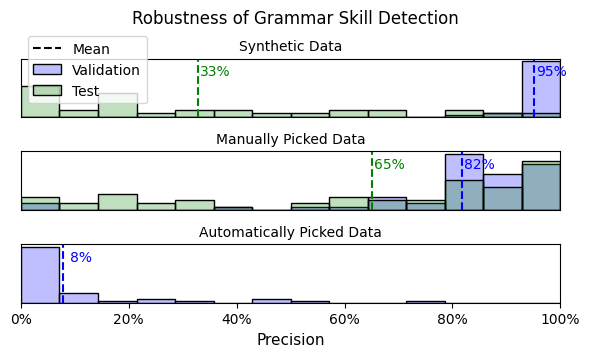

In [53]:
fig, axes = plt.subplots(len(approaches), 1, figsize=(6, 3.6))

for i, (name, approach) in enumerate(approaches.items()):
    print(name)
    validation_dat = approach['validation']
    print(len(validation_dat))
    test_dat = approach['test']
    print(len(test_dat))
    mean1 = np.mean(validation_dat)
    
    bins = np.linspace(0, 1, 15)
    
    sns.histplot(data=validation_dat, color='blue', bins=bins, kde=False, alpha=0.25, label='Validation' if i==0 else None, ax=axes[i])
    sns.histplot(data=test_dat, color='green', bins=bins, kde=False, alpha=0.25, label='Test' if i==0 else None, ax=axes[i])
    
    axes[i].axvline(x=mean1, color='blue', linestyle='--')
    
    axes[i].text(mean1+0.033, axes[i].get_ylim()[1]*0.66, f'{mean1:.0%}', color='blue', ha='center', va='bottom')
    
    if i == 0:
        axes[i].axvline(x=-1, color='black', linestyle='--', label="Mean")
        axes[i].legend()
        sns.move_legend(axes[i], "upper left", bbox_to_anchor=(0, 1.5))
    if i < 2:
        axes[i].set_xticklabels([])
        axes[i].set_xticks([])

        mean2 = np.mean(test_dat)
        axes[i].axvline(x=mean2, color='green', linestyle='--')
        axes[i].text(mean2+0.033, axes[i].get_ylim()[1]*0.66, f'{mean2:.0%}', color='green', ha='center', va='bottom')
    
    else:
        axes[i].set_xlabel('Precision', fontsize=11)
        axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
        
    axes[i].set_xlim(0,1)
    axes[i].set_ylabel('Frequency' if i == -1 else "")
    
    axes[i].set_yticklabels([])
    axes[i].set_yticks([])
    axes[i].set_title(name, fontsize=10)

plt.suptitle("Robustness of Grammar Skill Detection")
plt.tight_layout(rect=[0, 0, 1, 1.07])
plt.savefig("../results/detection_robustness.pdf")
plt.show()